# Averserial learning at scale - Kurakin et al
Here we give an insight of the adverserial attack methods that were studied in the paper by Kurakin,Goodfellow, & Bengio 2017) . We show the performance of the methods in preventing the correct classification of a simple example image. As model we used the pretrained ResNet-50 model for classification of the ImageNet dataset.

In [72]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

import json
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.autograd import Variable
import torch.nn.functional as F

In [69]:
# read the image, resize to 224 and convert to PyTorch Tensor
image = Image.open("kopje.jpg")

# Standard normalization values for ImageNet images, 
# obtained from https://github.com/pytorch/examples/blob/master/imagenet/main.py
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
   transforms.Normalize(mean, std)
])

# add batch dimension
image_tensor = preprocess(image).unsqueeze(0)

image_variable = Variable(image_tensor, requires_grad=True)

In [77]:
def show_image(image_variable, pred_label, prob):
    """
    
    """
    # remove batch dimension
    img = image_variable.squeeze(0)
    
    # Undo normalizations
    img = img.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).detach().numpy()

    # Convert C X H X W -->  H X W X C
    img = np.transpose(img, (1,2,0))   
    img = np.clip(img, 0, 1)
    
    figure, ax = plt.subplots(1,1, figsize=(4,4))
    
    ax.imshow(img)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

    
    ax.text(0.5, -0.2,
            'Prediction: {}\n Probability: {:.4f}'.format(pred_label, prob),
            size=12, ha="center", transform=ax.transAxes)
    
    plt.show()
    

In [78]:
# Load pre-trained ResNet50, and put model into| evaluation mode 
model = resnet50(pretrained=True)
model.eval();


In [79]:
# Load labels corresponding to ImageNet class indices
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

# Original model performance
Here, we show the performance of the model on the original image

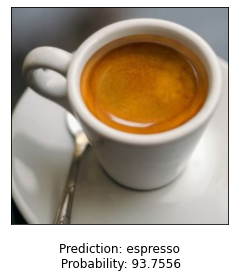

In [80]:
pred = model(image_variable)

pred_label = imagenet_classes[pred.max(dim=1)[1].item()]
probs = F.softmax(pred, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(image_variable, pred_label, prob)


# Fast Gradient Sign Method
The Fast Gradient Sign Method was first proposed by Goodfellow (2014) **insert citation**. It is a one-step method.

$$
\boldsymbol{X}^{adv} = \boldsymbol{X} + \epsilon\, \text{sign}{\nabla_x J(\boldsymbol{X}, y_{true})}
$$

In [81]:
y_true = 967
epsilon = 0.4

pred = model(image_variable)

model.zero_grad()

loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([y_true]))

loss.backward(retain_graph=True)

perturbed_image = image_variable + epsilon * image_variable.grad.data.sign()

pred_perturbed = model(perturbed_image)

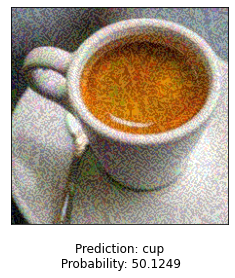

In [82]:
pred_label = imagenet_classes[pred_perturbed.max(dim=1)[1].item()]
probs = F.softmax(pred_perturbed, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(perturbed_image, pred_label, prob)

# One step least-likely class
A variation of the FGSM method, that aims to maximize the probability $P(y_{target} | \boldsymbol{X})$ towards an unlikely target class $y_{target}$.
$$
\boldsymbol{X}^{adv} = \boldsymbol{X} - \epsilon\, \text{sign}{\nabla_x J(\boldsymbol{X}, y_{LL})}
$$
Where $y_{LL} = \arg \min_y p(y | \boldsymbol{X})$ represents the least likely class.

In [83]:
# find least likely class
pred = model(image_variable)
y_target = torch.argmin(pred).item()
print('least likely class: {}'.format(imagenet_classes[y_target]))

epsilon = 0.4

pred = model(image_variable)

model.zero_grad()

loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([y_target]))

loss.backward(retain_graph=True)

perturbed_image = image_variable - epsilon * image_variable.grad.data.sign()

pred_perturbed = model(perturbed_image)

least likely class: dam


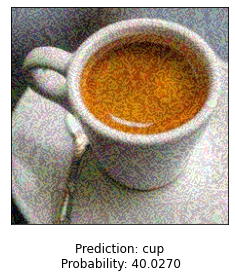

In [84]:
pred_label = imagenet_classes[pred_perturbed.max(dim=1)[1].item()]
probs = F.softmax(pred_perturbed, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(perturbed_image, pred_label, prob)

# Basic iterative method attack

Iterative methods apply many gradient updates. The Basic iterative method extends FGSM method, by applying the FGSM method multiple times with small step size:

$$
\boldsymbol{X}^{adv}_0 = \boldsymbol{X},\quad \boldsymbol{X}^{adv}_{N+1} = Clip_{\boldsymbol{X},\epsilon} \{ \boldsymbol{X}^{adv}_{N} + \epsilon\, \text{sign}\nabla_x J(\boldsymbol{X}^{adv}_{N}, y_{true}) \}
$$

In [85]:
# reset the gradients
image_variable.grad.data.zero_()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [86]:
y_true = 967
epsilon = 0.2
alpha = .25
num_steps = 3

for i in range(num_steps):
    
    pred = model(image_variable)

    loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([y_true]))
    
    loss.backward()
        
    x_adv_temp = image_variable.data + alpha * image_variable.grad.data.sign()
    
    total_grad = x_adv_temp - image_tensor
    
    image_variable.data = image_tensor + total_grad.data.clamp(-epsilon, epsilon)


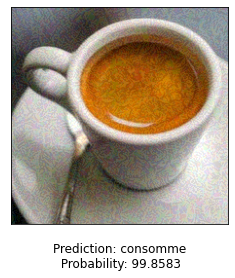

In [87]:
pred = model(image_variable)

pred_label = imagenet_classes[pred.max(dim=1)[1].item()]
probs = F.softmax(pred, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(image_variable, pred_label, prob)


In [92]:
# reset the gradients
image_variable.grad.data.zero_()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

# Iterative leasy-likely class method
An iterative method that applies the one-step least-likely class method multiple times:
$$
\boldsymbol{X}^{adv}_0 = \boldsymbol{X},\quad \boldsymbol{X}^{adv}_{N+1} = Clip_{\boldsymbol{X},\epsilon} \{ \boldsymbol{X}^{adv}_{N} - \epsilon\, \text{sign}\nabla_x J(\boldsymbol{X}^{adv}_{N}, y_{LL})\}
$$

In [89]:
# find least likely class
pred = model(image_variable)
y_target = torch.argmin(pred).item()
print('least likely class: {}'.format(imagenet_classes[y_target]))

epsilon = 0.3
alpha = 0.025
num_steps = 7

for i in range(num_steps):
    
    pred = model(image_variable)

    loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([y_target]))
    
    loss.backward()
        
    x_adv_temp = image_variable.data - alpha * image_variable.grad.data.sign()
    
    total_grad = x_adv_temp - image_tensor
    
    image_variable.data = image_tensor + total_grad.data.clamp(-epsilon, epsilon)


least likely class: ptarmigan


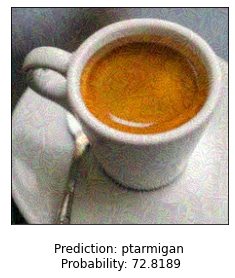

In [90]:
pred = model(image_variable)

pred_label = imagenet_classes[pred.max(dim=1)[1].item()]
probs = F.softmax(pred, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(image_variable, pred_label, prob)


# Performance on adverserial trained model

# References

In [ ]:
Kurakin, A., Goodfellow, I., & Bengio, S. (2017). Adversarial Machine Learning at Scale. ArXiv:1611.01236 [Cs, Stat]. http://arxiv.org/abs/1611.01236